## Getting images from Google

We have used the **"googleimagesdownload"** library to download the images of the trending clothes with the keyword "day dress"

The command for scraping images - **googleimagesdownload -k <url of the image> -o "output_dir"**
  
Link to the library - https://github.com/hardikvasa/google-images-download

## Fusing Google Drive onto the file system

In [1]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

## Setting up the directory working folder

In [2]:
# We have already created a folder directory called "Fashion_Gans" with the scraped data inside it

# !mkdir drive
# !google-drive-ocamlfuse drive
# !ls drive/"Fashion_Gans"/data/

In [3]:
# import h5py
# import numpy as np
# from PIL import Image

# h5_file = h5py.File('fashion dataset/train.h5', 'r')
# for i in range(len(h5_file['input_image'])):
#    img = Image.fromarray(h5_file['input_image'][i].astype('uint8'), 'RGB')
#    img.save("images/image" + str(i) + ".jpeg", "JPEG")

## Importing required libraries

In [4]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## Initializing the parameters

In [5]:
# Root directory for dataset
dataroot = 'image/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

## Retrieving the scraped data and creating the dataset

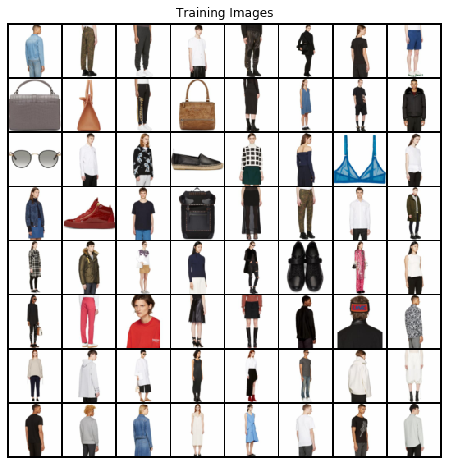

In [6]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Randomly initializing weights and biases

In [7]:
# All model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator code

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## Creating the Generator

In [9]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator code

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## Creating the Discriminator

In [11]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Setting up the optimizers

In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training the model

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1

Starting Training Loop...
[0/5][0/2036]	Loss_D: 1.6289	Loss_G: 5.6297	D(x): 0.6576	D(G(z)): 0.6081 / 0.0066
[0/5][50/2036]	Loss_D: 1.1495	Loss_G: 21.1614	D(x): 0.9903	D(G(z)): 0.4352 / 0.0000
[0/5][100/2036]	Loss_D: 1.7541	Loss_G: 4.9153	D(x): 0.9693	D(G(z)): 0.7350 / 0.0165
[0/5][150/2036]	Loss_D: 0.8158	Loss_G: 0.5927	D(x): 0.5227	D(G(z)): 0.0072 / 0.5917
[0/5][200/2036]	Loss_D: 0.4905	Loss_G: 5.3571	D(x): 0.9695	D(G(z)): 0.3309 / 0.0103
[0/5][250/2036]	Loss_D: 0.2668	Loss_G: 3.8270	D(x): 0.7996	D(G(z)): 0.0180 / 0.0313
[0/5][300/2036]	Loss_D: 0.6758	Loss_G: 2.1048	D(x): 0.7826	D(G(z)): 0.2862 / 0.1837
[0/5][350/2036]	Loss_D: 0.8043	Loss_G: 6.6547	D(x): 0.9527	D(G(z)): 0.4987 / 0.0024
[0/5][400/2036]	Loss_D: 0.9286	Loss_G: 1.8332	D(x): 0.4662	D(G(z)): 0.0274 / 0.2095
[0/5][450/2036]	Loss_D: 0.4280	Loss_G: 2.3910	D(x): 0.7357	D(G(z)): 0.0640 / 0.1213
[0/5][500/2036]	Loss_D: 1.2413	Loss_G: 1.6864	D(x): 0.3650	D(G(z)): 0.0213 / 0.2950
[0/5][550/2036]	Loss_D: 0.3557	Loss_G: 3.7348	D(x): 

[2/5][750/2036]	Loss_D: 0.7666	Loss_G: 1.3471	D(x): 0.5638	D(G(z)): 0.1020 / 0.3164
[2/5][800/2036]	Loss_D: 0.5275	Loss_G: 2.7632	D(x): 0.8634	D(G(z)): 0.2814 / 0.0915
[2/5][850/2036]	Loss_D: 0.4309	Loss_G: 2.4954	D(x): 0.8410	D(G(z)): 0.1948 / 0.1117
[2/5][900/2036]	Loss_D: 0.6500	Loss_G: 4.3554	D(x): 0.9184	D(G(z)): 0.3859 / 0.0180
[2/5][950/2036]	Loss_D: 0.3735	Loss_G: 2.8445	D(x): 0.8483	D(G(z)): 0.1603 / 0.0743
[2/5][1000/2036]	Loss_D: 1.2362	Loss_G: 5.7568	D(x): 0.9710	D(G(z)): 0.6423 / 0.0054
[2/5][1050/2036]	Loss_D: 0.7446	Loss_G: 4.1115	D(x): 0.9189	D(G(z)): 0.4344 / 0.0235
[2/5][1100/2036]	Loss_D: 0.5384	Loss_G: 1.9980	D(x): 0.6679	D(G(z)): 0.0715 / 0.2175
[2/5][1150/2036]	Loss_D: 0.9716	Loss_G: 6.8000	D(x): 0.9616	D(G(z)): 0.5431 / 0.0026
[2/5][1200/2036]	Loss_D: 0.4320	Loss_G: 2.1913	D(x): 0.7405	D(G(z)): 0.0845 / 0.1498
[2/5][1250/2036]	Loss_D: 0.4927	Loss_G: 3.2220	D(x): 0.9172	D(G(z)): 0.3054 / 0.0521
[2/5][1300/2036]	Loss_D: 0.4738	Loss_G: 3.1605	D(x): 0.8731	D(G(z)): 0

[4/5][1500/2036]	Loss_D: 0.2919	Loss_G: 3.5372	D(x): 0.9171	D(G(z)): 0.1590 / 0.0438
[4/5][1550/2036]	Loss_D: 1.7236	Loss_G: 0.7007	D(x): 0.2412	D(G(z)): 0.0477 / 0.5939
[4/5][1600/2036]	Loss_D: 0.3577	Loss_G: 3.3274	D(x): 0.8891	D(G(z)): 0.1856 / 0.0517
[4/5][1650/2036]	Loss_D: 0.1561	Loss_G: 3.2273	D(x): 0.9384	D(G(z)): 0.0802 / 0.0647
[4/5][1700/2036]	Loss_D: 0.3934	Loss_G: 2.9874	D(x): 0.7630	D(G(z)): 0.0744 / 0.0803
[4/5][1750/2036]	Loss_D: 0.2080	Loss_G: 3.2411	D(x): 0.8866	D(G(z)): 0.0691 / 0.0642
[4/5][1800/2036]	Loss_D: 0.2626	Loss_G: 4.1931	D(x): 0.9310	D(G(z)): 0.1449 / 0.0246
[4/5][1850/2036]	Loss_D: 0.3402	Loss_G: 4.0441	D(x): 0.9066	D(G(z)): 0.1724 / 0.0246
[4/5][1900/2036]	Loss_D: 0.3100	Loss_G: 3.3217	D(x): 0.8039	D(G(z)): 0.0585 / 0.0629
[4/5][1950/2036]	Loss_D: 0.1910	Loss_G: 2.9955	D(x): 0.8641	D(G(z)): 0.0288 / 0.0795
[4/5][2000/2036]	Loss_D: 2.9538	Loss_G: 4.6525	D(x): 0.9721	D(G(z)): 0.8826 / 0.0200


## Plotting the Generator and Discriminator loss

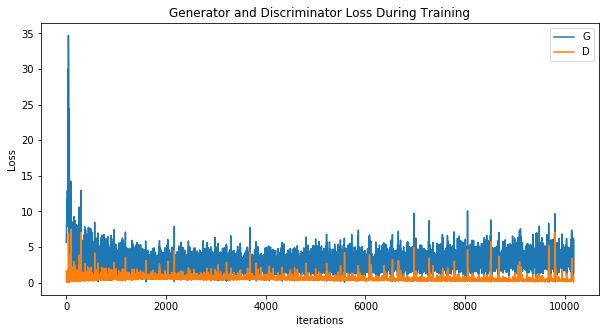

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Animation showing the GANs model data generation

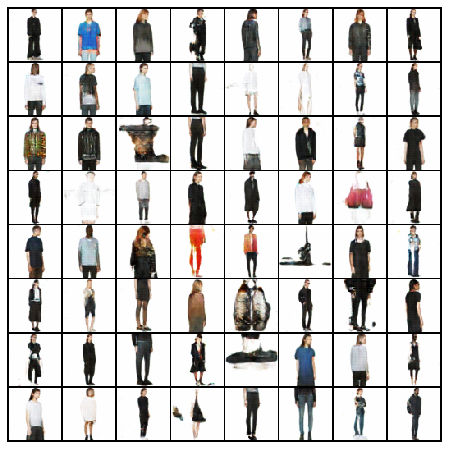

In [15]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Comparing the real data with fake generated data

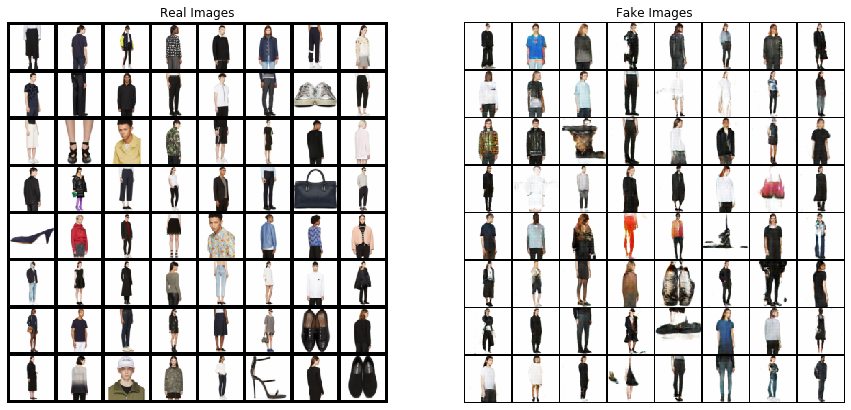

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()